## Contents:
* [General overview](#general-overview)
* [Imports and config](#import-config)
* [Data inpsection and preparation](#data-prep)
* [Model training](#model-creation)
* [Model evaluation](#model-evaluation)
* [Create endpoint from model](#endpoint)

## General overview <a class="anchor" id="general-overview"></a>

Our goal is to create an ML model that can predict with high accuracy the angle at which a boat should be heading, given metadata features such as boat speed, wind speed, attack angle and target angle. Rather than performing a regression to predict the angle directly, we will instead create two models for predicting the cosine and sine, respectively. This notebook is concerned with predicting the cosine of boat's angle.

As a counter-candidate model for linear regression, we will create a (non-linear) regression model using Keras. In addition to this, we will use cosine and sine of the angles involved as features, rather than the angles themselves.

**Important findings** after running the experiments below:
1. Minimizing MSE is a better strategy than minimizing MAE;
2. Non-linear regression outperforms linear regression;
3. Wider models outperform deeper models. This is not immediately obvious, but seems to be the case in regression tasks involving other well-known datasets, see for example [here](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
4. The best model is either 2-hidden layers of sizes (256, 128) OR 2-hidden layers of sizes (512, 256).

## Basic imports <a class="anchor" id="import-config"></a>

In [1]:
import pandas as pd
import numpy as np
import io
import time
import json
import sagemaker.amazon.common as smac
import os
import boto3
import re
import sagemaker
from os.path import join
from sklearn.model_selection import train_test_split

## Setup the config

In [2]:
ROLE = sagemaker.get_execution_role()
REGION = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix

BUCKET = 'virtual-regatta-ml'
PREFIX = 'non_linear_keras_cosine' # place to upload training files within the bucket
TEST_NAME = 'default'
ENDPOINT_NAME = 'VR-keras-cos-endpoint-' + time.strftime("%Y-%m-%d-%H-%M", time.gmtime())
INSTANCE_TYPE = 'ml.t2.medium'
                                                            

## Load the data <a class="anchor" id="data-prep"></a>

In [3]:
df_reordered = pd.read_csv('../data-pre-processing/cosine_data.csv')

print(df_reordered.head())

   boat_speed  wind_speed  cos_attack_angle  sin_attack_angle  \
0     7.73236     9.43467         -0.829038         -0.559193   
1     7.78952     9.59005         -0.819152         -0.573576   
2     7.81913     9.66396         -0.819152         -0.573576   
3     7.81658     9.65759         -0.819152         -0.573576   
4     7.84463     9.72758         -0.819152         -0.573576   

   cos_target_angle  sin_target_angle  cos_boat_angle  
0         -0.829038         -0.559193       -0.866025  
1         -0.819152         -0.573576       -0.857167  
2         -0.809017         -0.587785       -0.857167  
3         -0.798636         -0.601815       -0.848048  
4         -0.777146         -0.629320       -0.848048  


In [4]:
corr = df_reordered.corr()
corr.style.background_gradient()

,boat_speed,wind_speed,cos_attack_angle,sin_attack_angle,cos_target_angle,sin_target_angle,cos_boat_angle
boat_speed,1.000000,0.783904,0.184568,-0.153520,0.146106,0.042199,0.082309
wind_speed,0.783904,1.000000,0.242784,-0.077306,0.468160,0.093278,0.420151
cos_attack_angle,0.184568,0.242784,1.000000,0.076631,0.164696,-0.119752,-0.083329
sin_attack_angle,-0.153520,-0.077306,0.076631,1.000000,-0.106529,0.468217,-0.253014
cos_target_angle,0.146106,0.468160,0.164696,-0.106529,1.000000,0.014174,0.617330
sin_target_angle,0.042199,0.093278,-0.119752,0.468217,0.014174,1.000000,0.096497
cos_boat_angle,0.082309,0.420151,-0.083329,-0.253014,0.617330,0.096497,1.000000


In [5]:
df_reordered.describe()

,boat_speed,wind_speed,cos_attack_angle,sin_attack_angle,cos_target_angle,sin_target_angle,cos_boat_angle
count,5992.000000,5992.000000,5992.000000,5992.000000,5992.000000,5992.000000,5992.000000
mean,5.857816,7.479423,0.163345,-0.145440,-0.046726,-0.342797,-0.144953
std,2.798221,4.672615,0.782194,0.583521,0.636874,0.689090,0.718187
min,0.000000,2.000000,-1.000000,-0.999848,-1.000000,-1.000000,-1.000000
25%,3.887192,4.251947,-0.707107,-0.681998,-0.573576,-0.974370,-0.777146
50%,5.073445,5.993845,0.642788,-0.241922,-0.104528,-0.587785,-0.484810
75%,7.475152,9.402362,0.866025,0.500000,0.374607,0.190809,0.573576
max,15.157860,21.077130,1.000000,1.000000,0.999848,1.000000,1.000000


## Create train-val-test split

In [6]:
def save_train_and_validation_data_to_s3(data) :
    test_col = 'cos_boat_angle'
    y_data = data[test_col]
    X_data = data.drop(columns=[test_col])
    X_data = X_data.to_numpy()
    y_data = y_data.to_numpy()
    
    # 70% training, 15% validation, 15% testing split
    train_X, test_X, train_y, test_y = train_test_split(X_data, y_data, train_size=0.7, random_state=42)
    
    val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, train_size=0.5, random_state=41)

    train_file = 'non_linear_train.data'

    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
    f.seek(0)
    boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(PREFIX, TEST_NAME, 'train', train_file)).upload_fileobj(f)
    validation_file = 'non_linear_validation.data'
    
    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
    f.seek(0)
    boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(PREFIX, TEST_NAME,'validation', validation_file)).upload_fileobj(f)
    return train_X, train_y, val_X, val_y, test_X, test_y

## Create a non-linear regression model using keras <a class="anchor" id="model-creation"></a>

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


# Build the model
def wide_keras_model(size_1, size_2):
    model = Sequential()
    model.add(Dense(size_1, input_dim=6, kernel_initializer='normal', bias_initializer='normal', activation='relu', name='hidden_1'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(size_2, kernel_initializer='normal', bias_initializer='normal', activation='relu', name='hidden_2'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(1, kernel_initializer='normal', bias_initializer='normal', activation='linear'))

    # Compile the model
    model.compile(loss="mean_squared_error",
                  optimizer='adam')
    return model

Using TensorFlow backend.


In [8]:
train_X, train_y, val_X, val_y, test_X, test_y = save_train_and_validation_data_to_s3(df_reordered)
train_y = np.expand_dims(train_y, axis=1)
val_y = np.expand_dims(val_y, axis=1)
test_y = np.expand_dims(test_y, axis=1)
print(f'Number of examples in training data: {len(train_y)}')
print(f'Number of examples in validation data: {len(val_y)}')
print(f'Number of examples in test data: {len(test_y)}')

Number of examples in training data: 4194
Number of examples in validation data: 899
Number of examples in test data: 899


### Use a manual grid search for best architecture using Validation data and EarlyStopping

In [9]:
from keras.callbacks import EarlyStopping
hidden_layer_sizes = [(64, 32), (128, 64), (256, 128), (512, 256), (1024, 512), (2048, 1024)]
models = []
scores = []
callback = EarlyStopping(
    monitor='val_loss',
    patience=15, 
    restore_best_weights=True,
    verbose=0)

for i, (size_1, size_2) in enumerate(hidden_layer_sizes):
    models.append(wide_keras_model(size_1, size_2))
    models[i].fit(
        train_X,
        train_y,
        epochs=200,
        batch_size=16,
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[callback])
    training_score = models[i].evaluate(train_X, train_y, verbose=0)
    val_score = models[i].evaluate(val_X, val_y, verbose=0)
    scores.append(val_score)
    print(f'Scores for hidden layer sizes {size_1} and {size_2}:')
    print(f'training MSE:{training_score:.4f}')
    print(f'validationMSE:{val_score:.4f}')
    print('\n')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









Scores for hidden layer sizes 64 and 32:
training MSE:0.0843
validationMSE:0.0895


Scores for hidden layer sizes 128 and 64:
training MSE:0.0640
validationMSE:0.0710


Scores for hidden layer sizes 256 and 128:
training MSE:0.0387
validationMSE:0.0470


Scores for hidden layer sizes 512 and 256:
training MSE:0.0331
validationMSE:0.0464


Scores for hidden layer sizes 1024 and 512:
training MSE:0.0318
validationMSE:0.0445


Scores for hidden layer sizes 2048 and 1024:
training MSE:0.0325
validationMSE:0.0474




## Evaluate best model on test data <a class="anchor" id="model-evaluation"></a>

In [10]:
best_idx = np.argmin(scores)
best_sizes = hidden_layer_sizes[best_idx]
best_model = models[best_idx]
best_model.summary()
test_score = best_model.evaluate(test_X, test_y, verbose=0)
print(f'Best performing model is of sizes {best_sizes} for hidden layers')
print(f'Best model MSE on the test set: {test_score:.4f}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 1024)              7168      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 532,481
Trainable params: 532,481
Non-trainable params: 0
_________________________________________________________________
Best performing model is of sizes (1024, 512) for hidden layers
Best model MSE on the test set: 0.0359


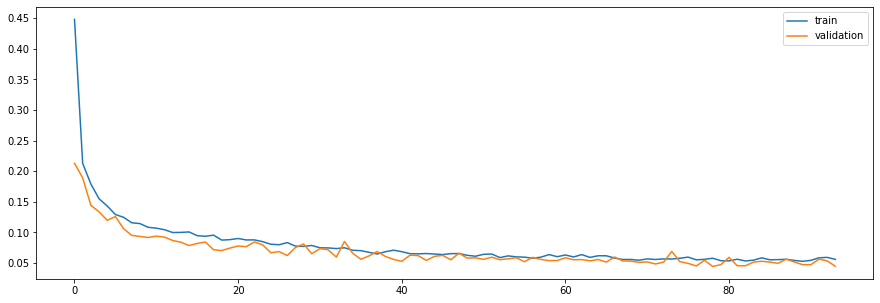

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(best_model.history.history['loss'], label='train')
plt.plot(best_model.history.history['val_loss'], label='validation')
plt.legend()
plt.show()

### Sanity check using different library

In [12]:
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde

test_pred = best_model.predict(test_X)
absolute_error = np.squeeze(np.absolute(test_pred - test_y))
print(f'TEST MAE: {np.mean(absolute_error):.4f}')
mse = mean_squared_error(test_y, test_pred)
print(f"Test MSE: {round(mse,4)}, \n")

abs_error = [(-e, i) for i, e in enumerate(absolute_error)]
abs_error.sort()
highest_errors = [
    f'{round(-e,3)}: ({test_pred[i][0]:.3f}, {round(test_y[i][0], 3)})' for e, i in abs_error]
print(f'Top highest absolute value errors on test data: \n {highest_errors[:10]} \n')
print(f'Top lowest absolute value errors on test data: \n {highest_errors[-10:]}')


TEST MAE: 0.1172
Test MSE: 0.0359, 

Top highest absolute value errors on test data: 
 ['1.54: (0.550, -0.99)', '1.039: (-0.308, 0.731)', '1.037: (-0.306, 0.731)', '1.012: (0.031, -0.982)', '0.922: (-0.422, 0.5)', '0.91: (-0.893, 0.017)', '0.887: (0.611, -0.276)', '0.817: (0.018, -0.799)', '0.765: (-0.660, 0.105)', '0.688: (0.078, 0.766)'] 

Top lowest absolute value errors on test data: 
 ['0.001: (-0.999, -1.0)', '0.001: (0.908, 0.906)', '0.001: (0.424, 0.423)', '0.001: (-0.514, -0.515)', '0.001: (-0.708, -0.707)', '0.001: (-0.732, -0.731)', '0.001: (0.719, 0.719)', '0.001: (-0.798, -0.799)', '0.001: (0.906, 0.906)', '0.0: (0.899, 0.899)']


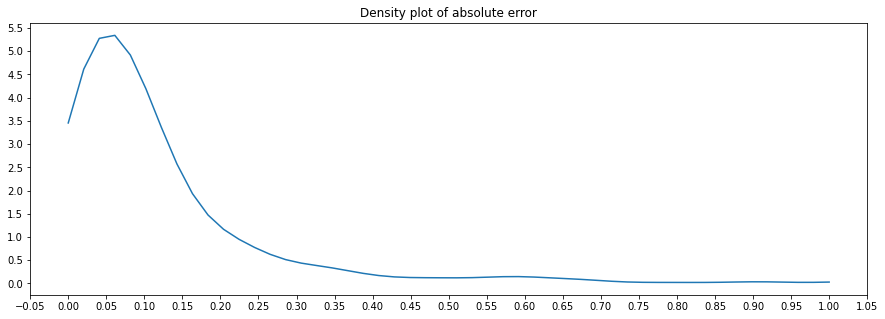

In [13]:
density = gaussian_kde(absolute_error)
xs = np.linspace(0,1,50)
plt.figure(figsize=(15,5))
plt.plot(xs,density(xs))
plt.locator_params(axis='y', nbins=20)
plt.locator_params(axis='x', nbins=30)
plt.title('Density plot of absolute error')
plt.show()

In [14]:
print(test_X.tolist()[:2])

[[3.57303, 4.66792, -0.7313537016191705, 0.6819983600624986, -0.8910065241883678, 0.4539904997395469], [6.3666599999999995, 10.05333, 0.5000000000000001, -0.8660254037844386, 0.9702957262759964, 0.2419218955996677]]


In [15]:
# stop here when running all cells to avoid creating endpoints unnecessarily
assert False

AssertionError: 

## Save best model and create an endpoint from it <a class="anchor" id="endpoint"></a>

In [ ]:
best_model.save_weights('keras_cosine_model/best_model_weights.h5')
model_json = best_model.to_json()
with open("keras_cosine_model/best_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import keras
from keras.models import model_from_json

In [ ]:
json_file = open('keras_cosine_model/best_model.json', 'r')
loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('keras_cosine_model/best_model_weights.h5')
json_file.close()

In [ ]:
!rm -rf export

In [ ]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

version_number = '1'
export_dir = 'export/Servo/' + version_number
builder = builder.SavedModelBuilder(export_dir)
signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})

from keras import backend as K
with K.get_session() as sess:
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()

In [ ]:
import tarfile

with tarfile.open('keras-cosine-model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='keras-cosine-model.tar.gz', bucket=BUCKET, key_prefix='keras_cosine_model')

In [ ]:
!touch train.py

from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + BUCKET + '/keras_cosine_model/keras-cosine-model.tar.gz',
                                  role = ROLE,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

In [ ]:
%%time
predictor = sagemaker_model.deploy(
    endpoint_name = ENDPOINT_NAME,
    initial_instance_count=1,
    instance_type=INSTANCE_TYPE)

### Call the endpoint

In [ ]:
import json

runtime = boto3.client('runtime.sagemaker')
payload = json.dumps(test_X.tolist())
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
test_pred = np.array([r for r in result['outputs']['score']['floatVal']])

## Sanity check evaluating the endpoint on test data again

In [ ]:
absolute_error = np.absolute(test_pred - np.squeeze(test_y))
print(f'TEST MAE: {np.mean(absolute_error):.4f}')
mse = mean_squared_error(test_y, test_pred)
print(f"Test MSE: {round(mse,4)}, \n")